In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np

In [2]:
# 设备配置
torch.cuda.set_device(1) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 如果没有文件夹就创建一个文件夹
sample_dir = 'results/'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


In [4]:
# 超参数设置
# Hyper-parameters
image_size = 784    # mnist数据集中一张图片的size，28*28
h_dim = 400 
z_dim = 20  
num_epochs = 15 # 迭代次数
batch_size = 128    # 一批样本的数量
learning_rate = 1e-3    # 学习率

In [6]:
# Pytorch的内置函数torchvision.datasets.MNIST，通过这个可以导入MNIST数据集。
dataset = torchvision.datasets.MNIST(root='./data/mnist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True) 
                                     # train=True表示从training.pt创建数据集即训练集，否则从test.pt创建数据集即测试集；MNIST数据集有60000张训练图片，10000张测试图片
                                     # transform=transforms.ToTensor()表示将shape从（H*W*C）转换成（C*H*W）
                                     # download=True表示root目录下没有MNIST数据集时就下载下来

torchvision.datasets.MNIST会自动下载MNIST数据集

In [7]:
print(dataset)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)
# 从数据库中每次抽取出batch_size个样本出来，DataLoader的好处就是可以快速迭代数据
print(data_loader)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/mnist
    Split: Train
    StandardTransform
Transform: ToTensor()


打印输出读取后的mnist数据集相关变量，输出vector和shape

In [18]:
print(len(data_loader))  # math.ceil(60000/128)
for step, (batch_x, batch_y) in enumerate(data_loader):
    print(step)     # 当前step
    print(batch_x)  # 输入（128*1*28*28）
    print(batch_y)  # 标签（128）
    save_image(batch_x,
                   os.path.join(sample_dir,
                                'origin-1.png'))  # 保存原始图片
    break
print('='*100)
# for input,label in data_loader:
#     print(input)
#     print(label)
#     break

469
0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  .

In [19]:
# VAE model
class VAE(nn.Module):

    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        # 调用父类方法初始化模块的state
        super(VAE, self).__init__()

        # 编码器： [b,input_dim]-->[b,z_dim]
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)  # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim)  # 保准方差 向量

        # 解码器：[b,z_dim]-->[b,input_dim]
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)

    # 编码过程
    def encode(self, x):
        """
        encoding part
        :param x: input image
        :return: mu and log_var
        """
        h = F.relu(self.fc1(x))
        mu = self.fc2(h)
        log_var = self.fc3(h)
        # return self.fc2(h), self.fc3(h)
        return mu, log_var

    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        """
        Given a standard gaussian distribution epsilon ~ N(0,1),
        we can sample the random variable z as per z = mu + sigma * epsilon
        :param mu:
        :param log_var:
        :return: sampled z
        """
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        """
        Given a sampled z, decode it back to image
        :param z:
        :return:
        """
        h = F.relu(self.fc4(z))
        x_reconst = F.sigmoid(self.fc5(h))
        # return F.sigmoid(self.fc5(h))
        return x_reconst

    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        """
        向前传播部分, 在model_name(inputs)时自动调用
        :param x: the input of our training model [b, batch_size, 1, 28, 28]
        :return: the result of our training model
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [20]:
# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

逐步打印输出训练过程的shape变化

In [17]:
test_x=torch.Tensor(128,2,28,28)
print(test_x.shape)
test_x=test_x.view(-1,2,image_size)
print(test_x.shape)

for i,(x,_) in enumerate(data_loader):
    print(x.shape)
    x = x.to(device).view(-1, image_size)   # 将vector变成二维，列数为image_size，行数根据原始维度计算
    print(x.shape)
    break

torch.Size([128, 2, 28, 28])
torch.Size([128, 2, 784])


In [13]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, image_size)   # 转换成二维（128,784）
        x_reconst, mu, log_var = model(x)

        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                "Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                .format(epoch + 1, num_epochs, i + 1, len(data_loader),
                        reconst_loss.item(), kl_div.item()))
    print(x_reconst.shape)  # VAE输出的vector维度是(96,784)
    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim).to(
            device)  # 随机生成一个vector，维度和输入到VAE decoder的vector一致，是(128,20)
        # print(z.shape)

        out = model.decode(z).view(
            -1, 1, 28, 28)  # 经过decoder之后，reshape成mnist数据集中图片vector的维度，是(128,1,28,28)
        # print(out.shape)

        # save_image(out,
        #            os.path.join(sample_dir,
        #                         'sampled-{}.png'.format(epoch + 1)))  # 保存生成的图片

        # 重构的图像
        # print(x.shape)
        out, _, _ = model(x)  # 对最后一个batch的样本进行重构，最后一个batch的样本只有96个，因此x的维度是(96,784)，输出的vector维度也是(96,784)
        # print(out.shape)
        
        x_concat = torch.cat([x.view(-1, 1, 28, 28),
                              out.view(-1, 1, 28, 28)],
                             dim=3)  # 将原始输入的向量和重构的向量拼接，拼接的是第3维，输出维度是(96,1,28,56)
        print(x_concat.shape)
        # save_image(x_concat,
        #            os.path.join(sample_dir,
        #                         'reconst-{}.png'.format(epoch + 1)))  # 保存重构的图片
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 784])


训练代码

In [23]:
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # 获取样本，并前向传播
        x = x.to(device).view(-1, image_size)   # 转换成二维（128,784）
        x_reconst, mu, log_var = model(x)

        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(
                "Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                .format(epoch + 1, num_epochs, i + 1, len(data_loader),
                        reconst_loss.item(), kl_div.item()))
    # print(x_reconst.shape)  # VAE输出的vector维度是(96,784)

    # 利用训练的模型进行测试
    with torch.no_grad():
        # 随机生成的图像
        z = torch.randn(batch_size, z_dim).to(
            device)  # 随机生成一个vector，维度和输入到VAE decoder的vector一致，是(128,20)
        # print(z.shape)

        out = model.decode(z).view(
            -1, 1, 28, 28)  # 经过decoder之后，reshape成mnist数据集中图片vector的维度，是(128,1,28,28)
        # print(out.shape)

        save_image(out,
                   os.path.join(sample_dir,
                                'sampled-{}.png'.format(epoch + 1)))  # 保存生成的图片

        # 重构的图像
        # print(x.shape)
        out, _, _ = model(x)  # 对最后一个batch的样本进行重构，最后一个batch的样本只有96个，因此x的维度是(96,784)，输出的vector维度也是(96,784)
        # print(out.shape)
        
        x_concat = torch.cat([x.view(-1, 1, 28, 28),
                              out.view(-1, 1, 28, 28)],
                             dim=3)  # 将原始输入的向量和重构的向量拼接，拼接的是第3维，输出维度是(96,1,28,56)
        # print(x_concat.shape)
        save_image(x_concat,
                   os.path.join(sample_dir,
                                'reconst-{}.png'.format(epoch + 1)))  # 保存重构的图片

/home/zhoujianping/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/zhoujianping/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/15], Step [100/469], Reconst Loss: 12679.3809, KL Div: 3077.8215
Epoch[1/15], Step [200/469], Reconst Loss: 11300.7686, KL Div: 3149.5408
Epoch[1/15], Step [300/469], Reconst Loss: 11598.4844, KL Div: 3020.6174
Epoch[1/15], Step [400/469], Reconst Loss: 11319.9727, KL Div: 3123.9634
torch.Size([96, 784])
torch.Size([96, 784])
torch.Size([96, 1, 28, 56])


torchvision.utils.save_image能够直接将tensor保存成灰度图片

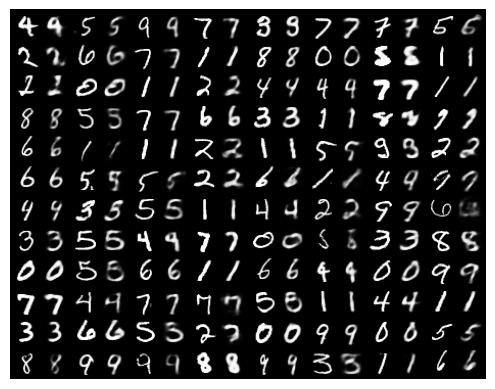

In [12]:
reconsPath = './results/reconst-2.png'
Image = mpimg.imread(reconsPath)
plt.imshow(Image) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()